# Milestone 1 Assignment - Capstone Proposal

## Author - Logan Downing
Datasci 420  
July 19, 2018

![](http://drivendata.materials.s3.amazonaws.com/pumps/pumping.jpg)
## Problem Definition - Data Mining the Water Table



Data from the Tanzanian Ministry of Water reveals the working state of thousands of water pumps across that country. The data include a plethora of features including pump age, type of management, cost of water and water source. The working state of each pump is included. Importantly, latitude and longitude of each pump is provided.

**Business problem**  
The challenge is to determine, given the characteristics of each water pump, whether you can predict which pumps are faulty. "A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania." (DrivenData.org)

**Data sources**  
Our base data come from the Tanzanian Ministry of Water via the DrivenData.org website:

* https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/

We add to that precipitation data from a U.S. modeling effort that estimates precipitation values:

* https://globalweather.tamu.edu/

We join the two datasets on latitude/longitude. The hypothesis here is that natural precipitation may affect the working state of water pumps because of their connection to agriculture (naturally rainy locations probably won't rely on pumps as much), and mechanical dependency (the operation of pumps in drier locations may be adversely affected by drought).



In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Acquire data, process fields, handle missing values

## Dataset #1. First handle the base dataset (water pump data)
Here we import the data downloaded from the Tanzanian Ministry of Water (via DrivenData.org website).

* https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/

I've already turned this into a CSV file provided locally.

In [2]:
f = 'data/train-reduced-features.csv'
df=pd.read_csv(f,na_values='?')

Some fields are not useful because of too many values or values are not predictive

In [3]:
# the following fields are not useful for predictions as they 
# are not well-reported or have too many values
drop_fields = ['funder','installer','wpt_name','subvillage','lga','ward','scheme_name']
df.drop( drop_fields, axis=1, inplace=True )

In [4]:
df.head()

id date_recorded  gps_height  longitude  latitude            basin  \
0  27121       1/15/13         805  29.607122 -4.906265  Lake Tanganyika   
1  36714       1/15/13         783  29.607201 -4.903016  Lake Tanganyika   
2  53529       1/15/13         783  29.610321 -4.912941  Lake Tanganyika   
3  43648       1/15/13         793  29.610965 -4.906904  Lake Tanganyika   
4  45482       2/10/13         783  29.611947 -4.837695  Lake Tanganyika   

   region_code  district_code  population public_meeting       ...        \
0           16              4        1000          False       ...         
1           16              4        1250           True       ...         
2           16              4        1250          False       ...         
3           16              4           1          False       ...         
4           16              3         105           True       ...         

  extraction_type_class management  management_group payment_type  \
0                 other      other             other   per bucket   
1              handpump        vwc        user-group      monthly   
2                 other      other             other   per bucket   
3                 other      other             other   per bucket   
4               gravity        vwc        user-group      unknown   

  quality_group quantity_group   source_type source_class  \
0          good            dry    river/lake      surface   
1          good         enough  shallow well  groundwater   
2          good            dry    river/lake      surface   
3          good            dry    river/lake      surface   
4          good   insufficient        spring  groundwater   

  waterpoint_type_group    status_group  
0    communal standpipe  non functional  
1             hand pump      functional  
2    communal standpipe  non functional  
3    communal standpipe  non functional  
4    communal standpipe  non functional  

[5 rows x 23 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
id                       59400 non-null int64
date_recorded            59400 non-null object
gps_height               59400 non-null int64
longitude                57588 non-null float64
latitude                 57588 non-null float64
basin                    59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
population               59400 non-null int64
public_meeting           56066 non-null object
scheme_management        55523 non-null object
permit                   56344 non-null object
construction_year        38691 non-null float64
extraction_type_class    59400 non-null object
management               59400 non-null object
management_group         59400 non-null object
payment_type             59400 non-null object
quality_group            59400 non-null object
quantity_group           59400 non-null object


In [6]:
df.describe()

id    gps_height     longitude      latitude   region_code  \
count  59400.000000  59400.000000  57588.000000  57588.000000  59400.000000   
mean   37115.131768    668.297239     35.149669     -5.885572     15.297003   
std    21453.128371    693.116350      2.607428      2.809876     17.587406   
min        0.000000    -90.000000     29.607122    -11.649440      1.000000   
25%    18519.750000      0.000000     33.285100     -8.643841      5.000000   
50%    37061.500000    369.000000     35.005943     -5.172704     12.000000   
75%    55656.500000   1319.250000     37.233712     -3.372824     17.000000   
max    74247.000000   2770.000000     40.345193     -0.998464     99.000000   

       district_code    population  construction_year  
count   59400.000000  59400.000000       38691.000000  
mean        5.630135    179.909983        1996.814686  
std         9.633442    471.482176          12.472045  
min         1.000000      0.000000        1960.000000  
25%         2.000000      0.000000        1987.000000  
50%         3.000000     25.000000        2000.000000  
75%         5.000000    215.000000        2008.000000  
max        80.000000  30500.000000        2013.000000

Latitude and longitude are required since we'll be joining with precipation data
based on those values. 

In [7]:
# drop records with missing lat/long
df = df[df.longitude>0]

Summary of number of records and records without missing values

In [8]:
print("Number of records (total):",len(df))
print("Number of records without missing values (total):",len(df.dropna()))

Number of records (total): 57588
Number of records without missing values (total): 32515


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57588 entries, 0 to 57587
Data columns (total 23 columns):
id                       57588 non-null int64
date_recorded            57588 non-null object
gps_height               57588 non-null int64
longitude                57588 non-null float64
latitude                 57588 non-null float64
basin                    57588 non-null object
region_code              57588 non-null int64
district_code            57588 non-null int64
population               57588 non-null int64
public_meeting           54612 non-null object
scheme_management        53838 non-null object
permit                   54532 non-null object
construction_year        38691 non-null float64
extraction_type_class    57588 non-null object
management               57588 non-null object
management_group         57588 non-null object
payment_type             57588 non-null object
quality_group            57588 non-null object
quantity_group           57588 non-null object


### Address some fields that need typing and imputation

Handle public_meeting, which is a boolean field with 2,976 missing values

In [10]:
# replace missing data with the far-most prevalent value
df.public_meeting.fillna(1.0,inplace=True)

# cast to int (comes in as float)
df.public_meeting = df.public_meeting.astype('int')

df.public_meeting.value_counts()

1    52713
0     4875
Name: public_meeting, dtype: int64

Handle permit, which is a boolean field with 2,931 missing values

In [11]:
# replace missing data with the far-most prevalent value
df.permit.fillna(1.0,inplace=True)

# cast to int (comes in as float)
df.permit = df.permit.astype('int')

df.permit.value_counts()

1    41156
0    16432
Name: permit, dtype: int64

### Handle duplicative fields

Scheme_management, management and management_group are duplicative; reduce to management_group

In [12]:
df.drop('scheme_management',axis=1,inplace=True)
df.drop('management',axis=1,inplace=True)

In [13]:
df.management_group.value_counts()

user-group    50767
commercial     3635
parastatal     1696
other           939
unknown         551
Name: management_group, dtype: int64

### Create new fields based on existing data

Handle construction_year, an ordinal value (year) with 18,897 missing values. Because year of construction is a critical field to predicting the outcome, drop records missing this value. Create a new field, age, that is the age of the water pump at the time of the recording.

In [14]:
# drop records missing construction_year
df = df[df.construction_year>0]

# cast to int (comes in as float)
df.construction_year = df.construction_year.astype('int')

In [15]:
# convert construction_year to age (in years). determine the age by subtracting 
# construction_year from the year of date_recorded (since the outcome is measured
# as of date_recorded, not today)
df['age'] = pd.DatetimeIndex(df.date_recorded).year - df.construction_year

### Handle the dependent variable

Handle the predicted class, status_group. Convert the three class outcomes to integer values for two outcomes: functional (1) and non-functional (0). (The third class has relatively fewer members than the others.)

In [16]:
df.status_group.value_counts()

functional                 21704
non functional             14459
functional needs repair     2528
Name: status_group, dtype: int64

In [17]:
# drop records with the "functional needs repair" category
df = df[df.status_group!='functional needs repair']

# convert the outcomes to nominal values (0,1)
df.status_group = df.status_group.map({'non functional':0, 'functional':1})

#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#le.fit(df.status_group)
#le.transform(df.status_group)

#### Review dataframe

Take a look at our data so far. We should have no missing values, and proper typing for all fields.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36163 entries, 0 to 57587
Data columns (total 22 columns):
id                       36163 non-null int64
date_recorded            36163 non-null object
gps_height               36163 non-null int64
longitude                36163 non-null float64
latitude                 36163 non-null float64
basin                    36163 non-null object
region_code              36163 non-null int64
district_code            36163 non-null int64
population               36163 non-null int64
public_meeting           36163 non-null int64
permit                   36163 non-null int64
construction_year        36163 non-null int64
extraction_type_class    36163 non-null object
management_group         36163 non-null object
payment_type             36163 non-null object
quality_group            36163 non-null object
quantity_group           36163 non-null object
source_type              36163 non-null object
source_class             36163 non-null object
wate

## Dataset #2. Join in weather data
Our base dataset has records encoded by latitude and longitude, covering the entire country of Tanzania. It will be interesting to also analyze the precipitation record for these locations, to see whether the amount of rainfall has an effect on the local water pumps. Several ideas come to mind:

* Residents of areas with more rainfall should depend on their pumps less for agriculture, therefore use of the pumps would be lower.
* Pumps located in locations with less rainfall may have a mechanical dependency on the amount of rain throughout the year. For example, in drought regions, the pumps may fail faster or more frequently than those in wetter regions.

We'll test to see whether precipation has a significant effect on the outcomes of the water pumps.



**Weather data source**  
Weather data come from The National Centers for Environmental Prediction (NCEP) Climate Forecast System Reanalysis (CFSR) located here:

* https://globalweather.tamu.edu/#pubs

The project provides an estimate of precipation based on a high-resolution coupled atmosphere-ocean-land surface-sea ice system. The daily precipitation estimates were pulled for most of Tanzania for 2011-2014 and averaged.

I've already downloaded the modeling data, concatentated it into one file, and created a pivot table based on latitude & longitude. You can read in the CSV file provided locally.

In [19]:
# read the weather data
f2 = 'data/daily-averages.csv'
df_weather=pd.read_csv(f2)
df_weather = df_weather.set_index('longitude')
df_weather.head()

-11.08409977  -10.77190018  -10.45969963  -10.1473999  \
longitude                                                          
30.0000        7.197107      5.142119      5.182173     6.338538   
30.3125        5.419931      5.343265      4.850051     5.696414   
30.6250        5.868158      5.452085      4.581703     5.020537   
30.9375        5.216105      5.121824      4.655299     4.923893   
31.2500        4.493019      4.886306      5.136068     5.944160   

           -9.835209846  -9.522979736  -9.210749626  -8.89852047  \
longitude                                                          
30.0000        5.801245      6.701620      9.072696     4.834446   
30.3125        6.052670      5.671849      6.318729     6.681164   
30.6250        5.135942      4.104278      4.966456    11.309917   
30.9375        4.634208      3.776100      4.837456     8.536906   
31.2500        5.079409      4.656589      5.789854     5.644836   

           -8.586290359  -8.274060249      ...       -6.400690079  \
longitude                                  ...                      
30.0000        2.486473      3.836343      ...           7.351521   
30.3125        5.270485      5.049364      ...           7.997645   
30.6250        8.310787      3.287709      ...           6.597163   
30.9375        2.683668      0.659970      ...           3.178496   
31.2500        0.991225      1.156887      ...           3.291513   

           -6.088459969  -5.776229858  -5.464000225  -5.151780128  \
longitude                                                           
30.0000        9.574211      4.179647      3.270569      3.373026   
30.3125        9.288292      5.225902      6.116801      6.455385   
30.6250        7.306457      6.190552      5.364570      3.976634   
30.9375        3.749500      4.009147      3.696238      2.644666   
31.2500        2.810486      2.638947      4.291516      4.617065   

           -4.839550018  -4.527319908  -4.215089798  -3.902859926  \
longitude                                                           
30.0000        7.046578     10.609975      9.259487     12.692452   
30.3125        8.632178      8.648603      2.505642      1.263862   
30.6250        4.941812      5.304285      2.327981      1.721979   
30.9375        3.486557      6.587949      8.854172     10.714864   
31.2500        4.505586      6.270077      7.832095      8.183984   

           -3.590630054  
longitude                
30.0000       12.249107  
30.3125        2.159516  
30.6250        3.142367  
30.9375       11.211425  
31.2500        5.815663  

[5 rows x 25 columns]

#### Distribution of precipitation across Tanzania
Here is a heatmap showing the daily predicted precipitation (in mm) averaged over four years 2011-2014. The vertical and horizontal axes are latitude and longitude, respectively. Notice how the modeling data predict certain "hotspots" for higher precipitation along a band of the country's mid-latitudes. 

The units are mm of precipitation daily. Most regions are in the 3-6 mm/daily regime (blues in the heatmap), which translates to some 36-75 inches annually (Compare to Seattle, which measures about 38 inches of rain annually.)

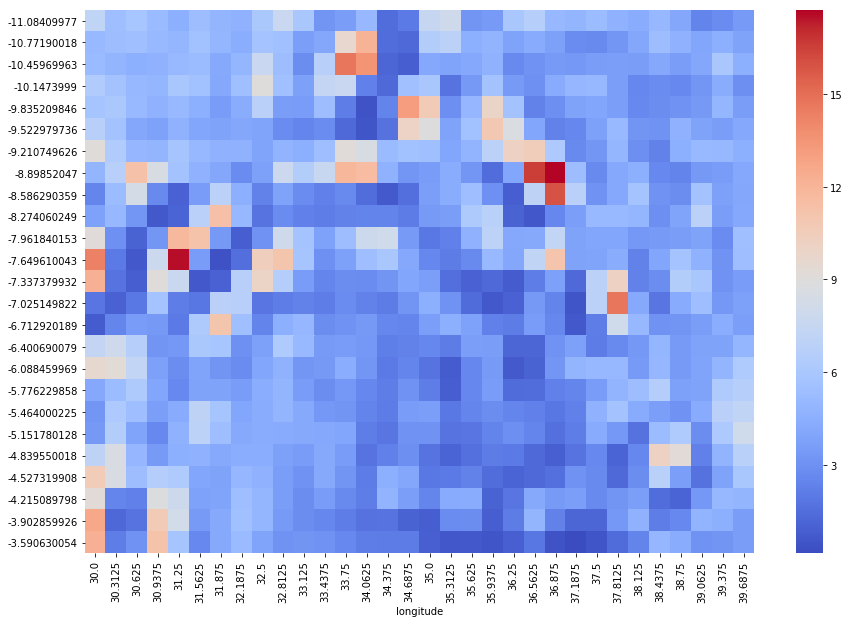

In [20]:
# weathermap: heatmap of daily average precip in mm
ax=plt.figure(figsize=(15,10)).gca()
sns.heatmap(df_weather.T,cmap='coolwarm')
_=""

### Explore the distribution of precipitation data in relationship with the locations of the water pumps.  
Here let's look at how the precipitation data is distributed in relationship with the location of water pumps across the country. This is important, because we'll soon join up precipitation data with the pump locations.

In [21]:
# make or get a plot of the locations of the waterpumps.
# there's a try/catch block in case you don't have folium installed.
from IPython.display import Image,display

try:

    import folium
    N = 500 # number of datapoints to plot (careful not to crash folium)
    m = folium.Map(location=[-6.537607,36.556195])
    def plotDot(point):
        '''input: series that contains a numeric named latitude and a numeric named longitude
        this function creates a CircleMarker and adds it to your this_map'''
        folium.CircleMarker(location=[point.latitude, point.longitude],
                            radius=1,
                            weight=2,
                            color='red'
                           ).add_to(m) 
    df.dropna().sample(N).apply(plotDot,axis=1)  

    # add the "weather stations" in blue
    for i in df_weather.columns.values:
        for j in df_weather.index.values:
            folium.CircleMarker(location=[float(i), float(j)],
                                radius=1,
                                weight=2,
                                color='blue'
                               ).add_to(m)

    m.fit_bounds( m.get_bounds())
    display(m)

except Exception as exception:

    # you don't have folium installed. here's a screenshot instead:
    im=Image('img/folium-map.png')
    print("You don't have folium installed. Displaying local image instead.")
    display(im)
    

Red dots are the locations of a  subset of the water pumps (reduced from the full set to avoid crashing folium). Blue dots are the locations of the precipitation estimates. 

### Join the precipitation data with the base dataset
Because the model predicts precipitation over a grid, we can assign precipitation values to each of the locations of the water pumps relatively easily. For each water pump, we find the precipitation measurement closest to that pump's latitude and longitude values.

In [22]:
def closest_xy(x,y,u,v):
    # given the numpy arrays u & v, find:
    #   - the value in u closest to x
    #   - the value in v closest to y
    # return as a tuple
    # example:
    # closest_xy(.5,.1,np.array([-10,-5,0,5,10,-20]), np.array([5,3,7,9,10]) ) 
    el1 = closest_x(x,u)
    el2 = closest_x(y,v)
    return (el1,el2)
    
def closest_x(x,arr):
    # return the element (its value) in arr closest to the value x.
    # example:
    #   closest_x(0,np.array([-10,-5,0,5,10,-20]) )  
    
    # check extreme values
    if x in arr: return x # might get lucky
    if x < arr.min(): return arr.min()
    if x > arr.max(): return arr.max()
    
    # element must be inside the bounds of the array. 
    # use a sorted array
    arr_sort = np.sort(arr)    
    
    # loop through the array and get the values just below and above the target value
    x_lower = 0
    x_upper = 0
    x_pos = 0
    for i,v in enumerate(arr_sort):
        if x>v and x<arr_sort[i+1]:
            x_lower = v
            x_upper = arr_sort[i+1]
            x_pos = i+1
            break

    #print(x_lower,x_upper,x_pos)
    
    # return whichever is closer 
    # because of the way we're using negative floats for our column labels,
    #   be sure they have 9 decimal places (the .asfloat() casting causes drift)
    if(x_lower<0):
        x_lower = float( "{0:.9f}".format(x_lower) )
    if(x_upper<0):
        x_upper = float( "{0:.9f}".format(x_upper) )
    return x_lower if np.abs(x-x_lower)<np.abs(x-x_upper) else x_upper
    
#closest_xy(-11,-5,np.array([-10,-5,0,5,10,-20]),np.array([-4,0,4,8]) )  
#closest_x(9,np.array([-20,-10,-5,0,5,10]) )
#closest_xy(-6.576130,36.526390,
#           df_weather.columns.values.astype('float'),df_weather.index.values.astype('float'))

In [23]:
# initialize the precip column
df['precip']=-999
def lookup_precip(s):
    lat=s.latitude
    long=s.longitude
    (wlat,wlong)=closest_xy(lat,long,df_weather.columns.values.astype('float'),df_weather.index.values.astype('float'))
    s.precip=df_weather.loc[float(wlong),"{}".format(wlat)]
    return s
df = df.apply(lookup_precip,axis=1)


Here's how our dataset looks post-processing

In [24]:
df.head()

id date_recorded  gps_height  longitude  latitude            basin  \
0  27121       1/15/13         805  29.607122 -4.906265  Lake Tanganyika   
1  36714       1/15/13         783  29.607201 -4.903016  Lake Tanganyika   
2  53529       1/15/13         783  29.610321 -4.912941  Lake Tanganyika   
3  43648       1/15/13         793  29.610965 -4.906904  Lake Tanganyika   
4  45482       2/10/13         783  29.611947 -4.837695  Lake Tanganyika   

   region_code  district_code  population  public_meeting    ...     \
0           16              4        1000               0    ...      
1           16              4        1250               1    ...      
2           16              4        1250               0    ...      
3           16              4           1               0    ...      
4           16              3         105               1    ...      

   management_group  payment_type quality_group quantity_group   source_type  \
0             other    per bucket          good            dry    river/lake   
1        user-group       monthly          good         enough  shallow well   
2             other    per bucket          good            dry    river/lake   
3             other    per bucket          good            dry    river/lake   
4        user-group       unknown          good   insufficient        spring   

  source_class waterpoint_type_group status_group age    precip  
0      surface    communal standpipe            0  42  7.046578  
1  groundwater             hand pump            1   3  7.046578  
2      surface    communal standpipe            0  42  7.046578  
3      surface    communal standpipe            0  42  7.046578  
4  groundwater    communal standpipe            0   5  7.046578  

[5 rows x 23 columns]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36163 entries, 0 to 57587
Data columns (total 23 columns):
id                       36163 non-null int64
date_recorded            36163 non-null object
gps_height               36163 non-null int64
longitude                36163 non-null float64
latitude                 36163 non-null float64
basin                    36163 non-null object
region_code              36163 non-null int64
district_code            36163 non-null int64
population               36163 non-null int64
public_meeting           36163 non-null int64
permit                   36163 non-null int64
construction_year        36163 non-null int64
extraction_type_class    36163 non-null object
management_group         36163 non-null object
payment_type             36163 non-null object
quality_group            36163 non-null object
quantity_group           36163 non-null object
source_type              36163 non-null object
source_class             36163 non-null object
wate

# Exporatory data analysis
Here we look at the individual fields and how their members are distributed. We look at categorical, ordinal and continuous fields.

## Continuous fields
Here are the fields that are numeric. We'll look at the fields that continuously-valued in this section:

* gps_height
* population
* age
* precipitation

In [26]:
def plot_hist(data,field="",title="",xlabel="",color='C0'):
    #ax=plt.figure(figsize=(12,6)).gca()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.hist(data,bins=30,edgecolor='silver',color=color)

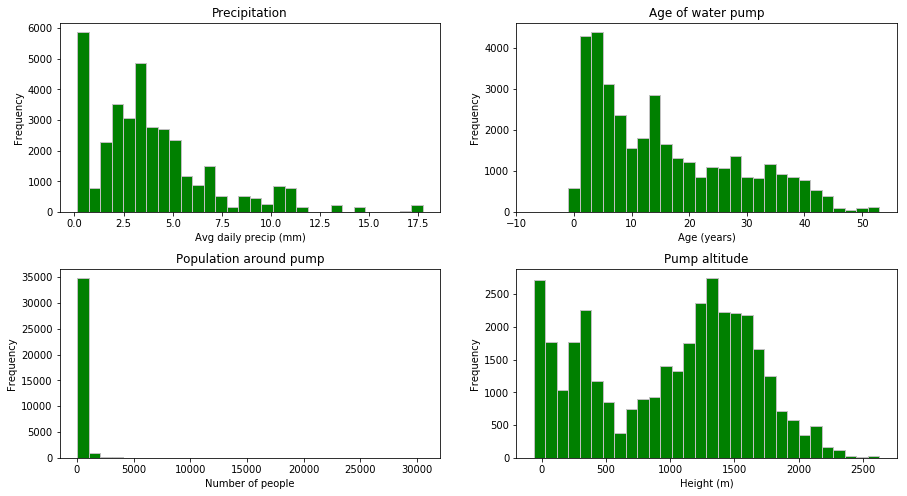

In [27]:
fig,axes=plt.subplots(2,2,figsize=(15,8))
plt.subplots_adjust(hspace=.3)

# precip
plt.axes(axes[0,0])
plot_hist(df.precip,title="Precipitation",xlabel="Avg daily precip (mm)",color='green')

# age
plt.axes(axes[0,1])
plot_hist(df.age,title="Age of water pump",xlabel="Age (years)",color='green')

# population
plt.axes(axes[1,0])
plot_hist(df.population,title="Population around pump",xlabel="Number of people",color='green')

# gps_height
plt.axes(axes[1,1])
plot_hist(df.gps_height,title="Pump altitude",xlabel="Height (m)",color='green')

Three of the four continuous fields span their domains nicely, and scaling will work fine for them (no outliers or extreme values). The population field however needs some work. The populations around most pumps number less than 100 people, with a relatively small number of pumps having populations greater than 1,000.

Bin the population variable to reduce complexity. We'll manually select bin sizes to get a natural distribution throughout the entire range of values.

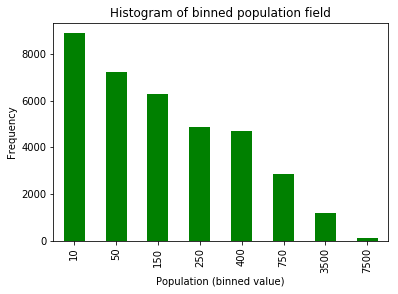

In [28]:
# bin up the populations into a smaller number of integer options, based on frequency
# labels are the midpoints of each bin (approx)
bins=  [0, 20,100,200,300,500,1000,5000,75000]
labels=[10,50,150,250,400,750,3500,7500]
bin_cut = pd.cut(df.population,retbins=True,bins=bins,labels=labels,include_lowest=True)
s=bin_cut[0].value_counts().sort_index()
s.plot(kind='bar',color='green',title="Histogram of binned population field")
plt.xlabel("Population (binned value)")
plt.ylabel("Frequency")
_=""

In [29]:
# and re-assign population to these binned values
df['population'] = bin_cut[0]

## Categorical fields
Next let's look at fields that are categorical. We'll look at these fields to get a sense of their distributions.

In [30]:
def plot_cat(data,field,title="",color="C0"):
    plt.title(title or field)
    plt.ylabel("Frequency")
    data[field].value_counts().plot(kind='bar',color=color)

def plot_two(data,field1,field2="",color='C0'):    
    fig,axes=plt.subplots(1,2,figsize=(15,6))
    plt.subplots_adjust(hspace=.3)

    # 1
    plt.axes(axes[0])
    plot_cat(data,field1,color=color)

    # 2
    if field2:
        plt.axes(axes[1])
        plot_cat(data,field2,color=color)    

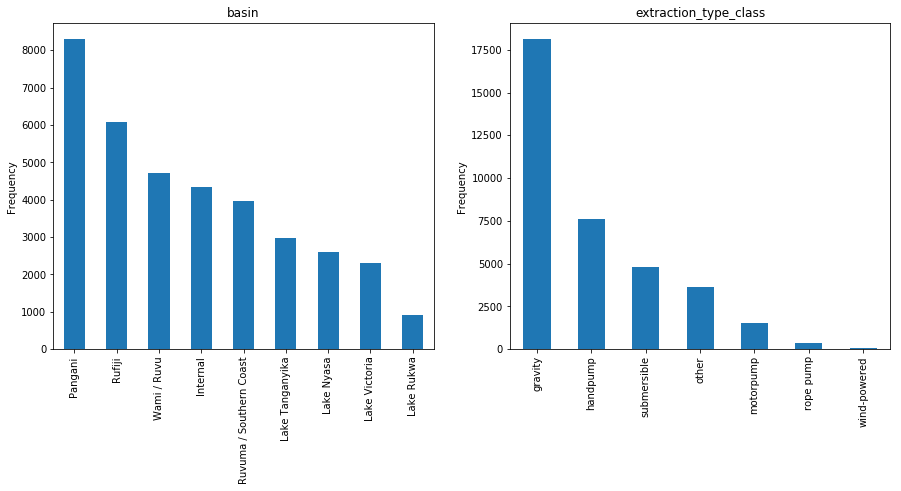

In [31]:
plot_two(df,'basin','extraction_type_class')

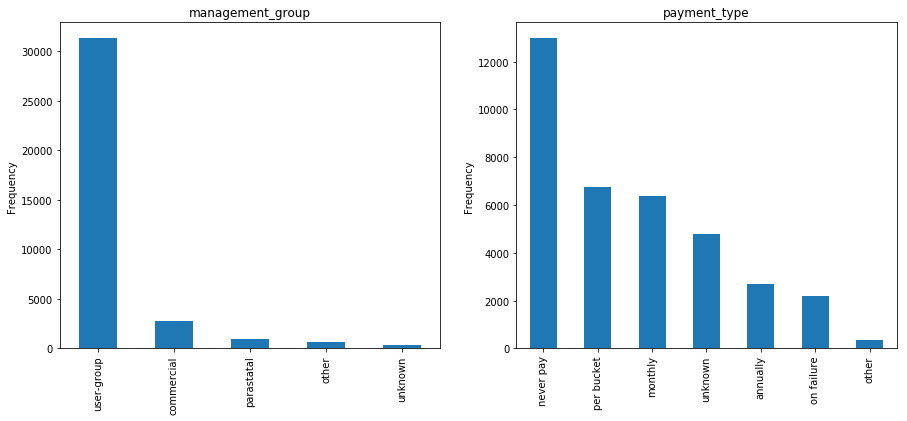

In [32]:
plot_two(df,'management_group','payment_type')

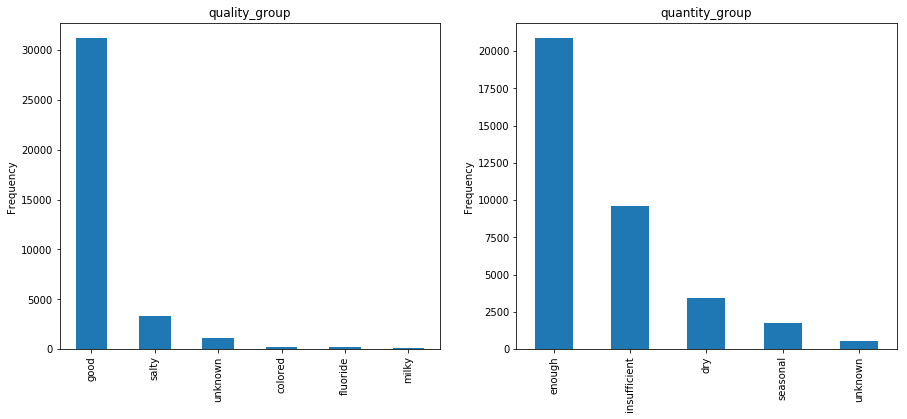

In [33]:
plot_two(df,'quality_group','quantity_group')

The quality_group field is probably useless as a predictor because it is so unbalanced.

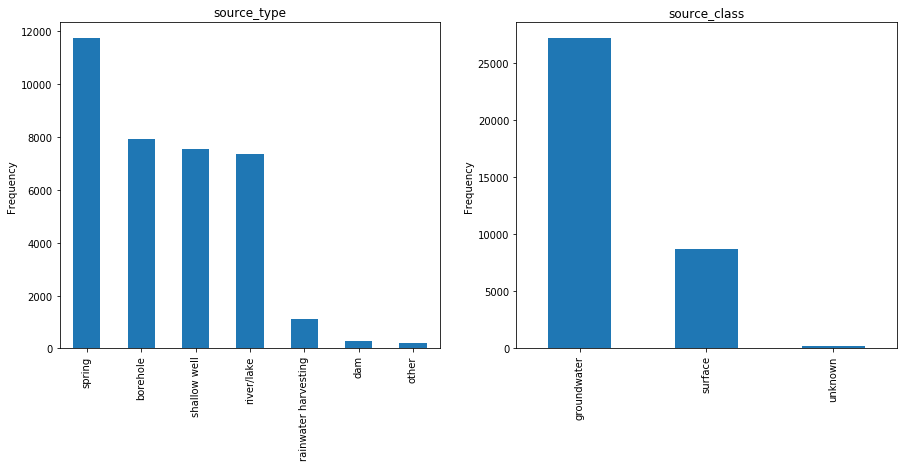

In [34]:
plot_two(df,'source_type','source_class')

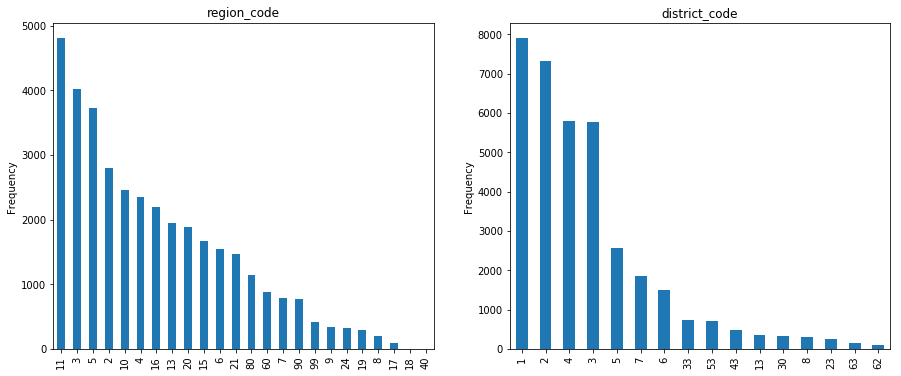

In [35]:
plot_two(df,'region_code','district_code')

Let's keep our eye on region_code and district_code. There's quite a bit of detail, which may lead to overfitting. We don't have the domain knowledge to be able to bin these accurately.

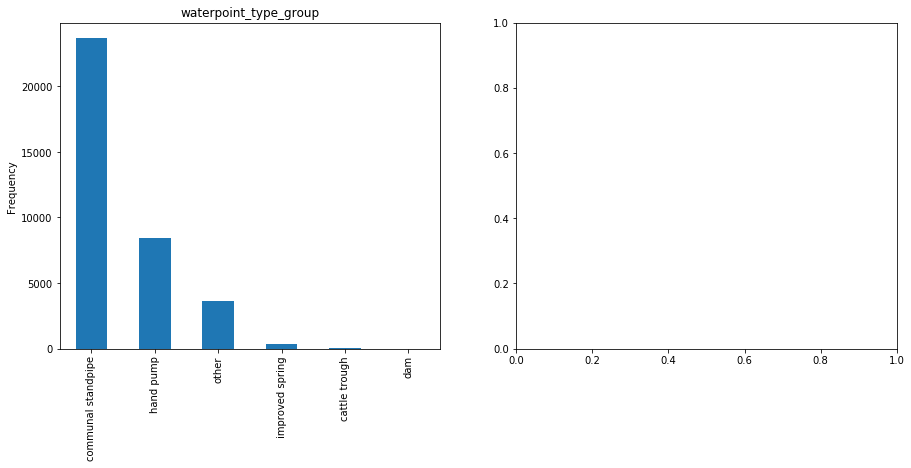

In [36]:
plot_two(df,'waterpoint_type_group')

Overall, the categorical data look good. There's a reasonable number of categories, and a good distribution of values among them.

## Boolean fields
Here are the fields that are boolean. We'll look at these fields to get a sense of their distributions.

* public_meeting
* permit

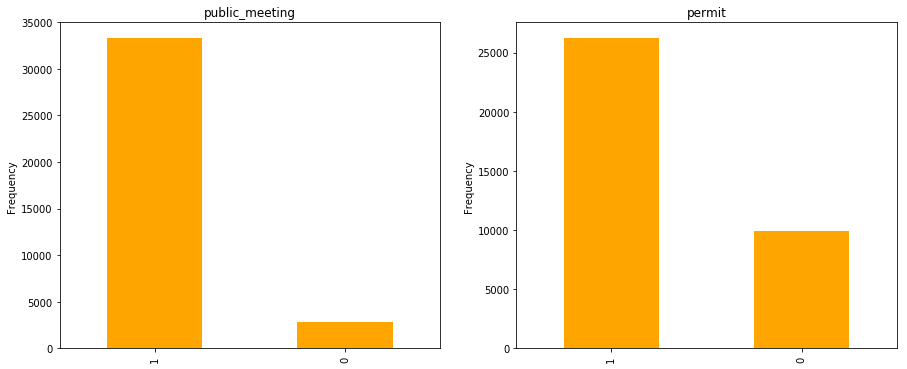

In [37]:
plot_two(df,'public_meeting','permit',color='orange')

The permit field has a moderate split between true and false. The public_meeting field looks much more lopsized; we'll keep an eye on this field going forward.

# Save out final data
Let's save out our final data to a csv file, which we'll use in subsequent steps.

In [38]:
f3 = 'data/LoganDowning-M01-dataset.csv'
df.to_csv(f3)

# Machine learning / Modeling plan
We have quite a bit of data to work with (10's of thousands of datapoints) and about a dozen features. We should be able to use a couple machine learning models effectively. The goal is to classify each record, so we'll choose some good classification approaches. Listed in order (expected best first):

1. **Logistic regression**. We have plenty of data to use to run a baseline logistic regression model. We should be able to come up with an effective set of fields to use in the model using the feature selection approaches we've studied.  
  
2. **Bernoulli Naive Bayes**. We have a fair number of categorical fields, so we'll have lots of binary features once we one-hot encode them. We can try a Bernoulli Naive Bayes approach which excels at binary input.  
  
3. **k-NN**. In order to use both the categorical and continuous features well, we can try a nearest neighbors approach to see if a distance metric between instances is predictive. There's a lot of features here, though, so we probably don't expect really great performance from this algorithm, but I'd like to try.
